# ECGR-5106 Homework 2

Patrick Flynn
ID: 801055057

### Problem 1

Let’s modernize LeNet as we did in the lectures. Implement and test the following changes over FashionMNIST

- Replace the average pooling with max-pooling.
- Replace the softmax layer with ReLU.

Start training from scratch based on FashinMNIST. Compare the training loss, training accuracy, and validation accuracy against the baseline we did in the lectures.



#### Part 1: Build FashionMNIST

Also verify that everything works.

In [ ]:
#!pip install torch==1.12.0 torchvision==0.13.0
!pip install torch
!pip install d2l==1.0.0b0
!pip install matplotlib_inline

In [ ]:
%matplotlib inline
import time
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import torch.nn.functional as F

d2l.use_svg_display()

In [ ]:
class FashionMNIST(d2l.DataModule):
    def __init__(self, batch_size  = 64, resize = (28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(root = self.root, train = True, transform = trans, download = True)
        self.val = torchvision.datasets.FashionMNIST(root = self.root, train = False, transform = trans, download = True)
    
    def text_labels(self, indicies):
        labels = [ "t-shirt", "trouser", "pullover", "dress", "coat", 
                  "sandal", "shirt", "sneaker", "bag", "ankle boot" ]
        return [labels[int(i)] for i in indicies]
    
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers = self.num_workers)
    
    def show_images(img, num_rows, num_cols, titles=None, scale=1.5):
        raise NotImplementedError
    
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)


In [ ]:
class SoftmaxRegression(d2l.Classifier):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))
    
    def forward(self, X):
        return self.net(X)

@d2l.add_to_class(d2l.Classifier)
def loss(self, Y_hat, Y, averaged = True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(Y_hat, Y, reduction="mean" if averaged else "none")

In [ ]:
data = FashionMNIST(resize = (32, 32))
print(len(data.train))
print(len(data.val))

60000
10000


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


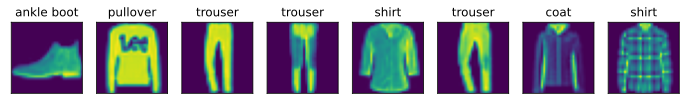

In [ ]:
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')


In [ ]:
data = FashionMNIST(batch_size = 256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


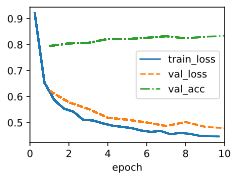

In [ ]:
trainer.fit(model, data)

loss 0.446, train acc 0.848, test acc 0.834
72375.9 examples/sec on cuda:0


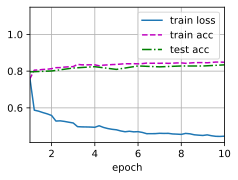

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

#### Part 2: Implement a convolutional neural network with FashionMNIST

In [ ]:
from torch import nn

def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, "output shape: \t", X.shape)
        

In [ ]:
model = LeNet()
model.layer_summary((1, 1, 28, 28))

data = FashionMNIST(batch_size = 128)
model = LeNet(lr=0.1)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)


Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


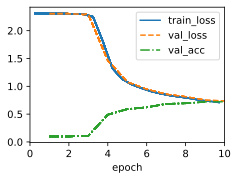

In [ ]:
trainer.fit(model, data)

loss 0.750, train acc 0.722, test acc 0.722
26734.5 examples/sec on cuda:0


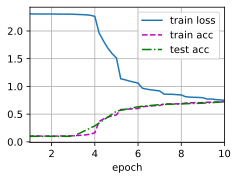

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

## Problem 1: Applied:

In [ ]:
from torch import nn

class LeNet2(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )
        

In [ ]:
model = LeNet2()
model.layer_summary((1, 1, 28, 28))

data = FashionMNIST(batch_size = 128)
model = LeNet2(lr=0.1)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
#trainer.fit(model, data)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


loss 0.685, train acc 0.742, test acc 0.743
26794.9 examples/sec on cuda:0


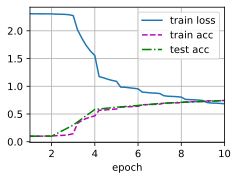

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

Both replaced:

In [ ]:
from torch import nn

class LeNet3(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )
        

In [ ]:
model = LeNet3()
model.layer_summary((1, 1, 28, 28))

data = FashionMNIST(batch_size = 128)
model = LeNet3(lr=0.1)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


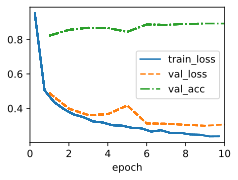

In [ ]:
trainer.fit(model, data)

loss 0.261, train acc 0.903, test acc 0.885
26988.8 examples/sec on cuda:0


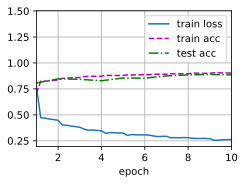

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

## Problem 2

Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU.

- Adjust the convolution window size. (DONE)
- Adjust the number of output channels (width of each layer). (DONE)
- Adjust the number of convolution layers. (DONE)
- Adjust the number of fully connected layers. (DONE)
- Explore the learning rates. (DONE- No effect)

For all training adjustments, restart training from scratch based on FashinMNIST. Compare the training loss, training accuracy, and validation accuracy against each other and the baseline in problem 1. Argue which adjustment presents the better benefit and generalization. Measure and compare theoretical computation complexity (number of operations and parameters size) using ptflops https://pypi.org/project/ptflops/

In [ ]:
from torch import nn

class LeNet4(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(3, kernel_size=15, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(15, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(5, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )
        

In [ ]:
data = FashionMNIST(batch_size = 128)
model = LeNet4(lr=0.1)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

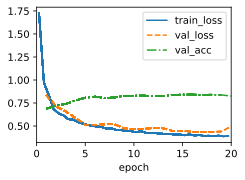

In [ ]:
trainer.fit(model, data)

loss 0.486, train acc 0.823, test acc 0.796
18697.0 examples/sec on cuda:0


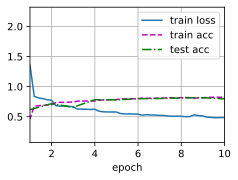

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

## Problem 3

Pick the best model from problem 2. Apply dropout to LeNet-5 across all experiments in problem 2. Does it improve the training? For all training adjustments, restart training from scratch based on FashinMNIST. Compare the training loss, training accuracy, and validation accuracy against the best model in problem 2.

In [ ]:
from torch import nn

class LeNet5(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(0.5), nn.LazyLinear(120), nn.ReLU(),
            nn.Dropout(0.5), nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )
        

In [ ]:
data = FashionMNIST(batch_size = 128)
model = LeNet5(lr=0.1)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

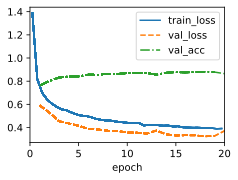

In [ ]:
trainer.fit(model, data)

loss 0.452, train acc 0.832, test acc 0.864
25672.5 examples/sec on cuda:0


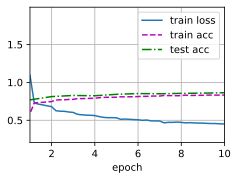

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

#### Dropout on the modified model above

In [ ]:
from torch import nn

class LeNet6(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(3, kernel_size=15, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(15, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(5, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.Flatten(),
            nn.Dropout(0.5), nn.LazyLinear(120), nn.ReLU(),
            nn.Dropout(0.5), nn.LazyLinear(84), nn.ReLU(),
            nn.Dropout(0.5), nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )
        

In [ ]:
data = FashionMNIST(batch_size = 128)
model = LeNet6(lr=0.1)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

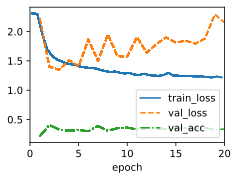

In [ ]:
trainer.fit(model, data)

loss 1.384, train acc 0.420, test acc 0.222
17338.4 examples/sec on cuda:0


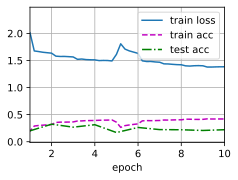

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

## Problem 4

AlexNet may be too complex for the Fashion-MNIST dataset, in particular, due to the low resolution of the initial images; try simplifying the model to make the training faster while ensuring that the accuracy stays relatively high. Compare your training loss, training, and validation accuracy against the best model in Problem 3 and Problem 2. Also, measure your computational saving in the number of operations as well as the number of parameters in your network using ptflops https://pypi.org/project/ptflops/

In [ ]:
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Best model of problem 2:

In [ ]:
class AlexNet1(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(32, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(64, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2),
            nn.LazyConv2d(64, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes)
        )
        self.net.apply(d2l.init_cnn)

In [ ]:
import torchvision.models as models
import torch
import ptflops
from ptflops import get_model_complexity_info

model = AlexNet1(lr=0.01)
data = d2l.FashionMNIST(batch_size=128)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)

#macs, params = ptflops.get_model_complexity_info(model.net, (1, 28, 28))
#print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
#print('{:<30}  {:<8}'.format('Number of parameters: ', params))

loss 0.503, train acc 0.822, test acc 0.800
9714.4 examples/sec on cuda:0


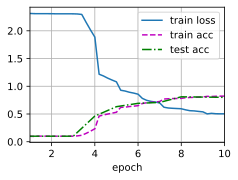

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())